To begin with we need to import the models we are testing, and some additional libraries/functions

In [1]:
from models import ClassifierWrapper, ClusteringWrapper, train_model,set_defaults,set_log_level, use_accel
from datagen import generate_classification_data, generate_clustering_data,loadFromParquet
from sklearn.model_selection import train_test_split
import logging as LOG
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
set_log_level(LOG.DEBUG)


Now we define our syntethic dataset

In [2]:
classifierXY = generate_classification_data(n_samples=100_000, n_features=20, n_informative=15, n_classes=2,sparsity=0.0, random_state=42)
classifierSplit = train_test_split(classifierXY[0], classifierXY[1], test_size=0.2, random_state=42)
clusteringXY = generate_clustering_data(n_samples=100_000, n_features=50, centers=10, cluster_std=1.0, random_state=42)


Subsequently we define the model parameters and models used for testing.


In [3]:
SEED = 42

setting={
    "classifier": {
        "estimator_name": "random_forest",
        "use_scaler": True,
        "random_state": SEED,
        "n_estimators": 100,
        "max_iter": 1000,
        "probability": True,
    },
    "clustering": {
        "algorithm_name": "kmeans",
        "n_clusters": 3,
        "use_scaler": True,
        "random_state": SEED,
        "algorithm_params": None,
    },
}
set_defaults(setting)

rfc = ClassifierWrapper()
kmc = ClusteringWrapper()

In [1]:
resultClassifier=train_model(model=rfc,X=classifierSplit[0],y=classifierSplit[2],X_val=classifierSplit[1],y_val=classifierSplit[3],timing=True)
resultClustering=train_model(kmc,X=clusteringXY[0],timing=True)
print("Classifier results:", resultClassifier)
print("Clustering results:", resultClustering)




KeyboardInterrupt



In [5]:
# Load and concatenate parquet files

df_classifier, df_clusterer = loadFromParquet()


print("Loaded rows of classifier dataset:", len(df_classifier), "columns:", list(df_classifier.columns))
print("Loaded rowsof clusterer dataset:", len(df_clusterer), "columns:", list(df_clusterer.columns))

Loaded rows of classifier dataset: 172 columns: ['n_samples', 'n_features', 'sparsity', 'accelerator', 'median_time', 'mean_time', 'algorithm']
Loaded rowsof clusterer dataset: 167 columns: ['n_samples', 'n_features', 'sparsity', 'accelerator', 'median_time', 'mean_time', 'algorithm']


Classifier speedup (first 10 rows):
accelerator  n_samples  n_features  sparsity       CPU      GPU1   speedup
0                 1000          64      0.00  0.477824  0.501859  0.952108
1                 1000          64      0.25  0.437523  0.632570  0.691659
2                 1000          64      0.50  0.385962  0.694864  0.555449
3                 1000          64      0.75  0.324535  0.719635  0.450972
4                 1000          64      0.90  0.278382  0.732415  0.380088
5                 1000         128      0.00  0.631865  0.715058  0.883656
6                 1000         128      0.25  0.565400  0.688475  0.821236
7                 1000         128      0.50  0.508525  0.711549  0.714674
8                 1000         128      0.75  0.377929  0.709511  0.532662
9                 1000         128      0.90  0.335042  0.780559  0.429233
Clustering speedup (first 10 rows):
accelerator  n_samples  n_features  sparsity       CPU      GPU1   speedup
0                 1000      

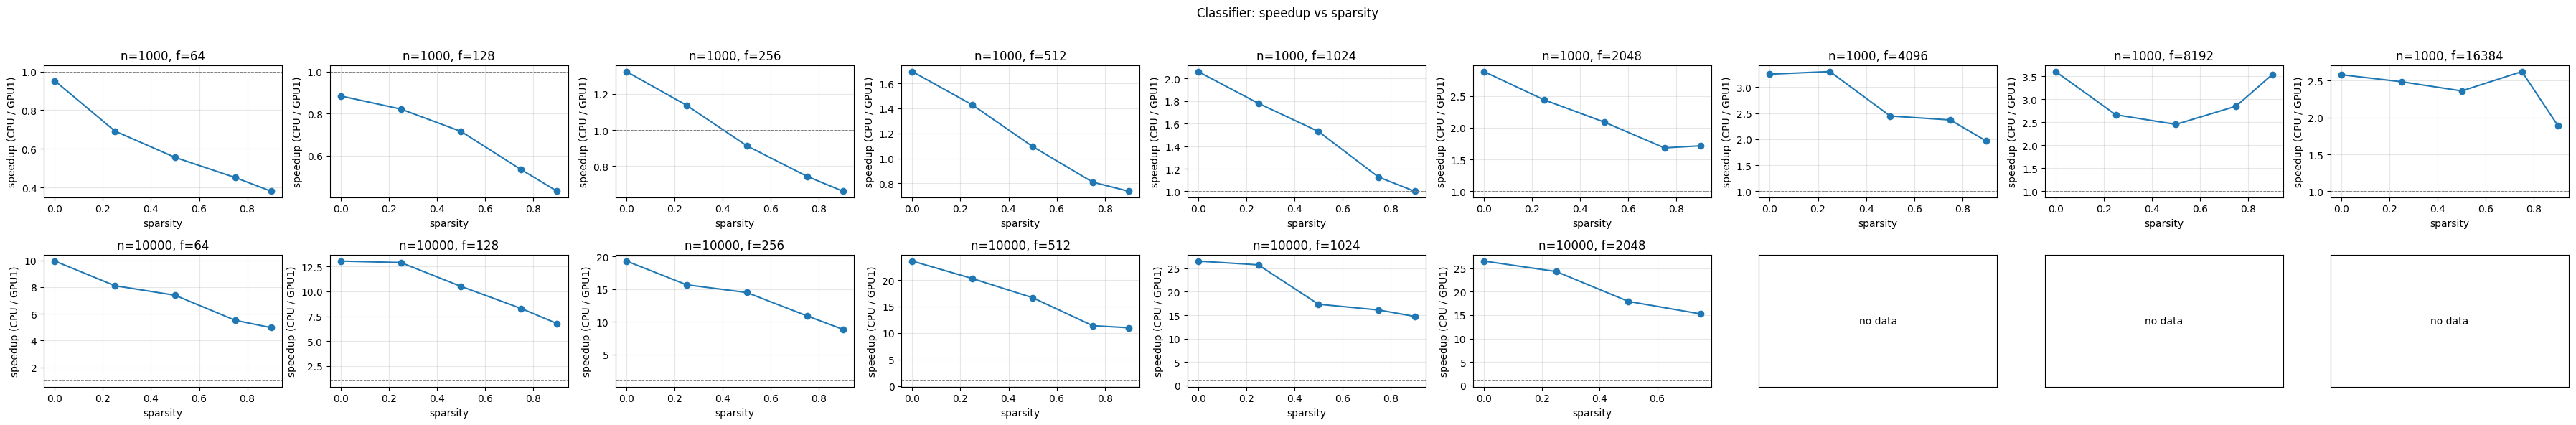

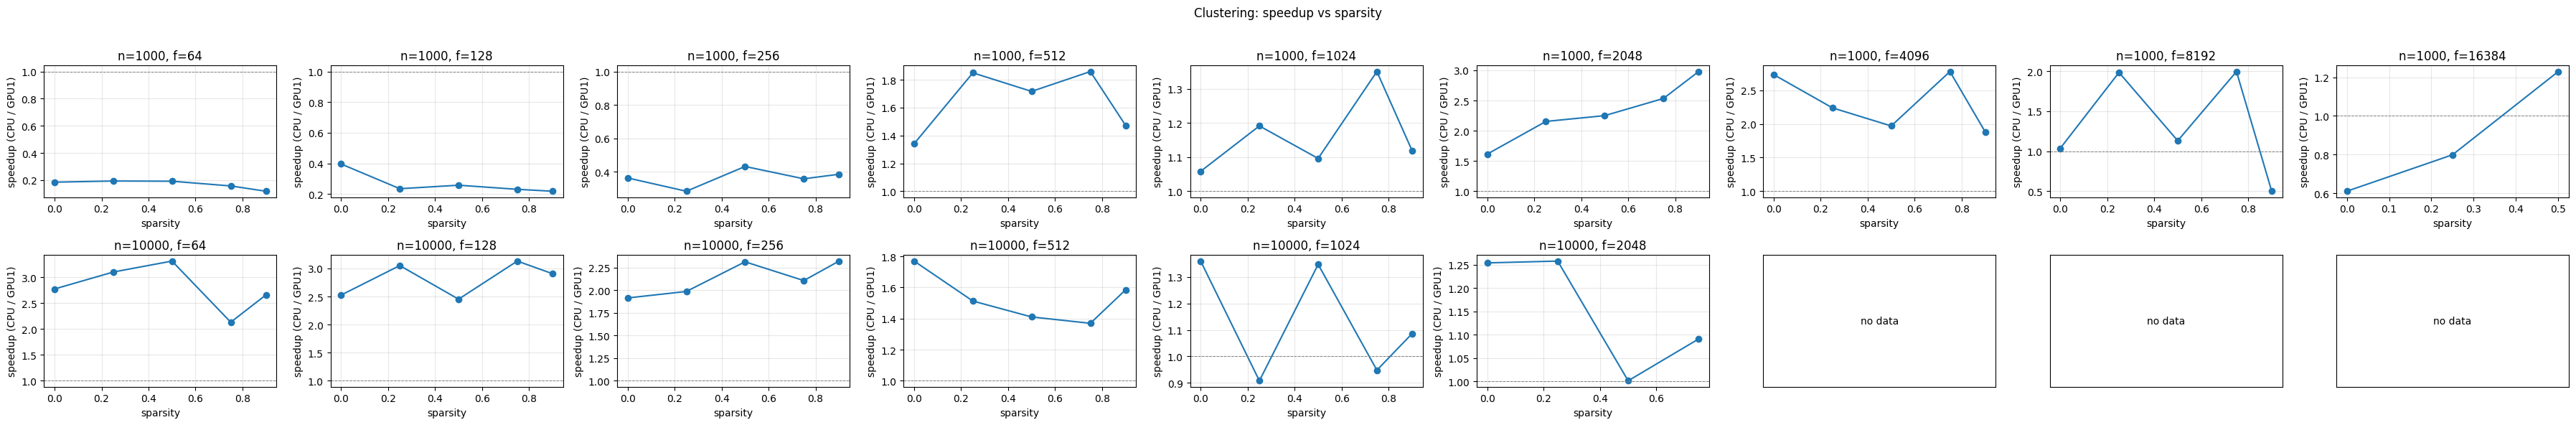

In [6]:
# Compute speedup (CPU mean_time / GPU1 mean_time) grouped by n_samples, n_features, sparsity
import numpy as np

def compute_speedup(df, cpu_label='CPU', gpu_label='GPU1'):
    # mean of mean_time per group+accelerator
    grp = df.groupby(['n_samples','n_features','sparsity','accelerator'])['mean_time'].mean().reset_index()
    pivot = grp.pivot_table(index=['n_samples','n_features','sparsity'], columns='accelerator', values='mean_time')
    pivot = pivot.reset_index()
    # ensure columns exist
    for col in [cpu_label, gpu_label]:
        if col not in pivot.columns:
            print(f'Missing accelerator column: {col} (available: {list(pivot.columns)})')
            # create column with NaNs so downstream code doesn't crash
            pivot[col] = np.nan
    # avoid division by zero
    pivot[gpu_label] = pivot[gpu_label].replace(0, np.nan)
    pivot['speedup'] = pivot[cpu_label] / pivot[gpu_label]
    return pivot

# Classifier speedups
speedup_classifier = compute_speedup(df_classifier, cpu_label='CPU', gpu_label='GPU1')
print('Classifier speedup (first 10 rows):')
print(speedup_classifier.head(10))

speedup_clustering = compute_speedup(df_clusterer, cpu_label='CPU', gpu_label='GPU1')
print('Clustering speedup (first 10 rows):')
print(speedup_clustering.head(10))







speedup_clustering_df = speedup_clustering
speedup_classifier_df = speedup_classifier# Optionally expose the results for further inspection 
print(speedup_clustering['speedup'].describe())
print('Summary stats for clustering speedup:')
print(speedup_clustering.head(10))
print('Clustering speedup (first 10 rows):')
speedup_clustering = compute_speedup(df_clusterer, cpu_label='CPU', gpu_label='GPU1')
# Plot speedup vs sparsity for all n_samples x n_features combinations
import matplotlib.pyplot as plt

def plot_speedup_grid(df, title):
    sp = compute_speedup(df, cpu_label='CPU', gpu_label='GPU1')
    sp = sp.dropna(subset=['speedup'])
    if sp.empty:
        print(f'No speedup data available for {title}')
        return
    ns_vals = sorted(sp['n_samples'].unique())
    nf_vals = sorted(sp['n_features'].unique())
    fig, axs = plt.subplots(len(ns_vals), len(nf_vals), figsize=(4*max(1,len(nf_vals)), 3*max(1,len(ns_vals))), squeeze=False)
    for i, ns in enumerate(ns_vals):
        for j, nf in enumerate(nf_vals):
            ax = axs[i][j]
            subset = sp[(sp['n_samples']==ns) & (sp['n_features']==nf)].sort_values('sparsity')
            if subset.empty:
                ax.text(0.5, 0.5, 'no data', ha='center', va='center')
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            ax.plot(subset['sparsity'], subset['speedup'], marker='o', linestyle='-')
            ax.axhline(1.0, color='gray', linestyle='--', linewidth=0.7)
            ax.set_title(f'n={ns}, f={nf}')
            ax.set_xlabel('sparsity')
            ax.set_ylabel('speedup (CPU / GPU1)')
            ax.grid(True, alpha=0.3)
    fig.suptitle(title)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

# Plot for classifier and clustering
plot_speedup_grid(df_classifier, 'Classifier: speedup vs sparsity')
plot_speedup_grid(df_clusterer, 'Clustering: speedup vs sparsity')


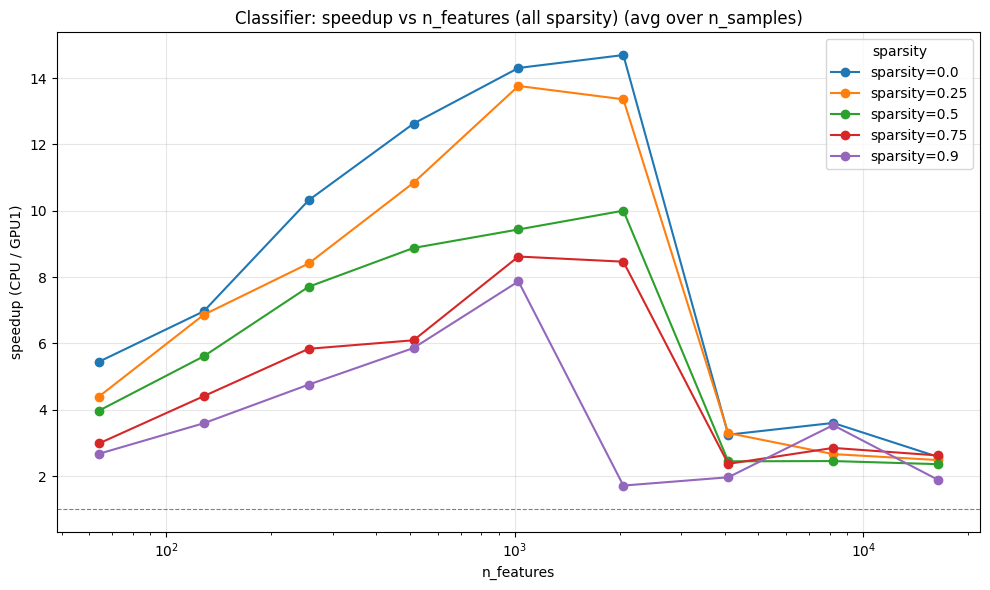

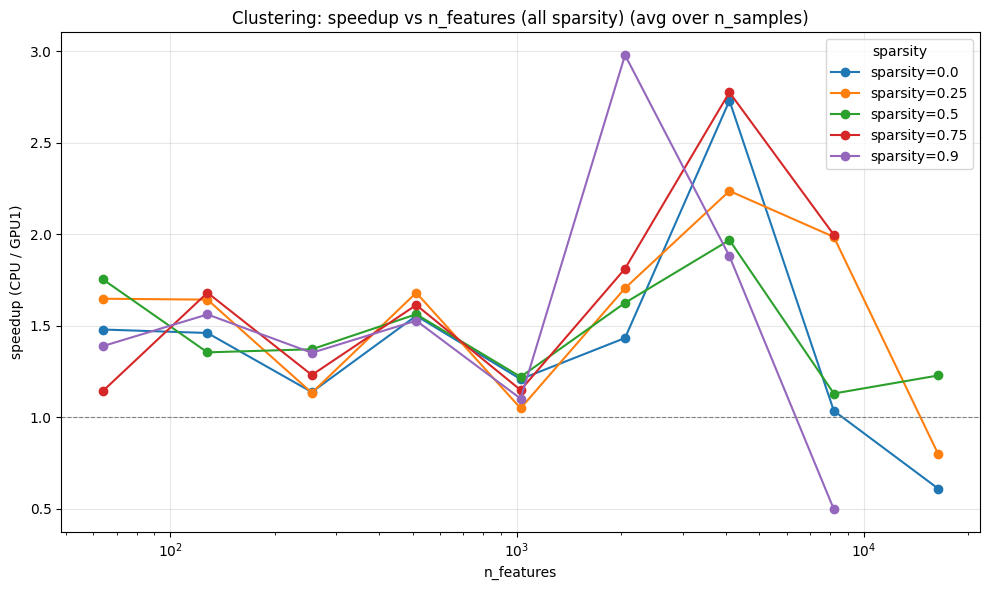

In [7]:
# Plot speedup vs n_features for all sparsity levels (averaging over n_samples)
import matplotlib.pyplot as plt

def plot_speedup_nfeatures_all_sparsity(df, title):
    sp = compute_speedup(df, cpu_label='CPU', gpu_label='GPU1')
    sp = sp.dropna(subset=['speedup'])
    if sp.empty:
        print(f'No speedup data available for {title}')
        return
    spars_vals = sorted(sp['sparsity'].unique())
    plt.figure(figsize=(10,6))
    for s in spars_vals:
        subset = sp[sp['sparsity'] == s]
        if subset.empty:
            continue
        # aggregate over n_samples by averaging speedup for each n_features
        agg = subset.groupby('n_features')['speedup'].mean().reset_index().sort_values('n_features')
        plt.plot(agg['n_features'], agg['speedup'], marker='o', label=f'sparsity={s}')
    plt.axhline(1.0, color='gray', linestyle='--', linewidth=0.8)
    plt.xlabel('n_features')
    plt.ylabel('speedup (CPU / GPU1)')
    plt.title(title + ' (avg over n_samples)')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend(title='sparsity')
    plt.tight_layout()
    plt.show()

# Run for classifier and clustering datasets
plot_speedup_nfeatures_all_sparsity(df_classifier, 'Classifier: speedup vs n_features (all sparsity)')
plot_speedup_nfeatures_all_sparsity(df_clusterer, 'Clustering: speedup vs n_features (all sparsity)')